In [569]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('GOOG.csv')
# df = pd.read_csv('AMZN.csv')
# df = pd.read_csv('AAPL.csv')


df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [570]:
print(df.shape)
df.info()

(1258, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   float64
 13  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.7+ KB


In [571]:
df.isnull().sum()

,0
symbol,0
date,0
close,0
high,0
low,0
open,0
volume,0
adjClose,0
adjHigh,0
adjLow,0


In [572]:
# Convert all column names to lowercase
df.columns = df.columns.str.lower()
df = df[['date','open','close']]
df['date'] = pd.to_datetime(df['date'].apply(lambda x: x.split()[0]))
df.set_index('date',drop=True,inplace=True)
df

<ipython-input-572-07e8ff8c21cc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'].apply(lambda x: x.split()[0]))


,open,close
date,,
2016-06-14,716.48,718.27
2016-06-15,719.00,718.92
2016-06-16,714.91,710.36
2016-06-17,708.65,691.72
2016-06-20,698.77,693.71
...,...,...
2021-06-07,2451.32,2466.09
2021-06-08,2479.90,2482.85
2021-06-09,2499.50,2491.40


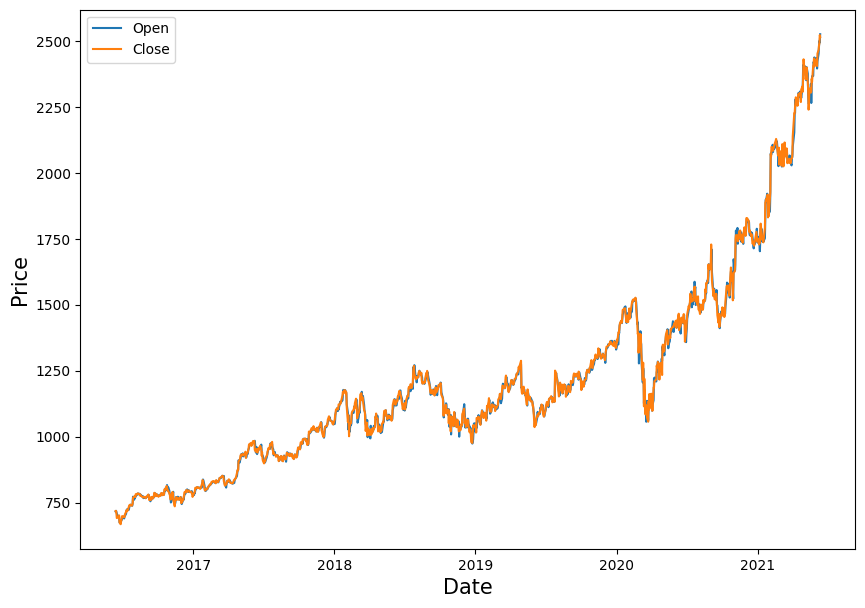

In [573]:
plt.figure(figsize=(10, 7))
plt.plot(df['open'], label='Open')
plt.plot(df['close'], label='Close')
plt.xlabel('Date', size=15)
plt.ylabel('Price', size=15)
plt.legend()
plt.show()


# LSTM

In [574]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler()
df[df.columns] = Scaler.fit_transform(df)


In [575]:
training_size = round(len(df) * 0.80)
train_data, test_data = df[:training_size], df[training_size:]
print("Training data shape=",train_data.shape,"Test data shape=",test_data.shape )

Training data shape= (1006, 2) Test data shape= (252, 2)


In [576]:
def create_datset(dataset):
  sequences = []
  labels = []

  start = 0
# Window of 50 rows at a time
  for stop in range(100,len(dataset)):
    sequences.append(dataset.iloc[start:stop])
    labels.append(dataset.iloc[stop])
    start += 1

  return (np.array(sequences),np.array(labels))

X_train, y_train = create_datset(train_data)
X_test, y_test = create_datset(test_data)

# print(X_train,"\n",y_train)
# print(X_test,"\n",y_test)

In [577]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

UNITS=70

model = Sequential()
model.add(LSTM(units=UNITS, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))

model.add(Dropout(0.1))
model.add(LSTM(units=UNITS))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [578]:
from keras.callbacks import EarlyStopping, Callback
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', # Monitor the validation loss
                               patience=10,        # Number of epochs with no improvement to wait before stopping
                               restore_best_weights=True) # Restore the best weights when stopping

class ManualInterventionCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Check if it's time for manual intervention (every 10 epochs)
        if (epoch + 1) % 10 == 0:
            response = input(f"Epoch {epoch + 1} completed. Do you want to continue training? (y/n): ")
            if response.lower() == 'n':
                print("Saving model and stopping training...")
                self.model.save('model_at_epoch_' + str(epoch + 1) + '.h5')
                self.model.stop_training = True  # Stop training
# Create the custom callback
manual_intervention = ManualInterventionCallback()

EPOCHS=50
BATCH_SIZE=20


model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), verbose=1

          ,callbacks=[early_stopping,manual_intervention]

          )
model.save('lstm_model.h5')

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.0132 - mean_absolute_error: 0.0818 - val_loss: 0.0080 - val_mean_absolute_error: 0.0779
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 5.6134e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0016 - val_mean_absolute_error: 0.0326
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 4.2443e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0039 - val_mean_absolute_error: 0.0508
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 4.3848e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0019 - val_mean_absolute_error: 0.0337
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 4.6358e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0036 - val_mean_absolute_error: 0.0483
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 3.7626e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0015 - val_mean_absolute_error: 0.0292
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 4.1730e-04 - mean_abs

Saving model and stopping training...
46/46 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 3.8164e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0050 - val_mean_absolute_error: 0.0615


In [592]:
test_predicted = model.predict(X_test)
test_inverse_predicted = Scaler.inverse_transform(test_predicted)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [593]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, test_predicted)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, test_predicted)
print(f'Mean Absolute Error: {mae}')

# Calculate R-squared (R2)
r2 = r2_score(y_test, test_predicted)
print(f'R-squared: {r2}')

Root Mean Squared Error: 0.03891271225183551
Mean Absolute Error: 0.029215583625316198
R-squared: 0.91598524245391


In [594]:
print(df.shape)
size=test_inverse_predicted.shape[0]*-1
print(size)
# merged = pd.concat([df.iloc[-202:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=df.iloc[-202:].index)], axis=1)# Merge actual and predicted data for visualization purposes
merged = pd.concat([df.iloc[size:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=df.iloc[size:].index)], axis=1)# Merge actual and predicted data for visualization purposes

merged[['open','close']] = Scaler.inverse_transform(merged[['open','close']])
merged.head()

(1258, 2)
-152


,open,close,open_predicted,close_predicted
date,,,,
2020-11-03,1631.78,1650.21,1608.055664,1603.672119
2020-11-04,1710.28,1749.13,1613.614258,1609.308716
2020-11-05,1781.00,1763.37,1625.557129,1621.342041
2020-11-06,1753.95,1761.75,1643.893433,1639.511963
2020-11-09,1790.90,1763.00,1664.718994,1659.809692


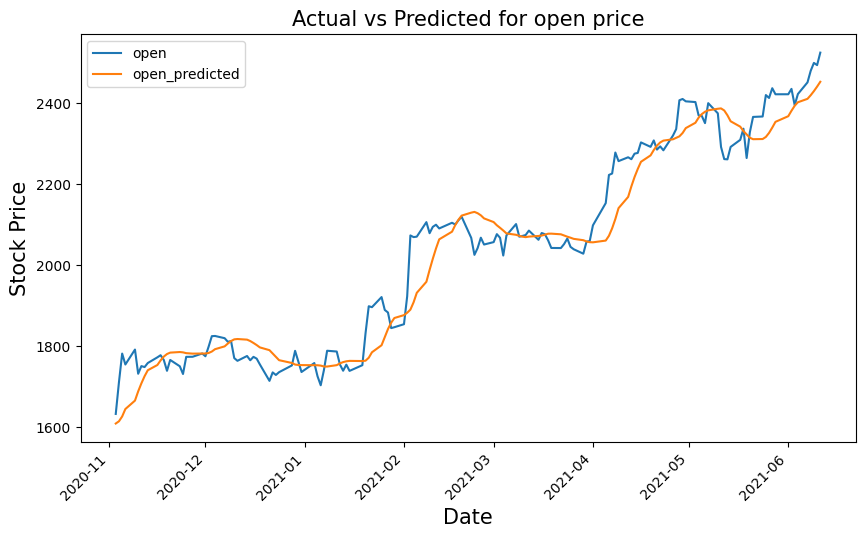

In [595]:
merged[['open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

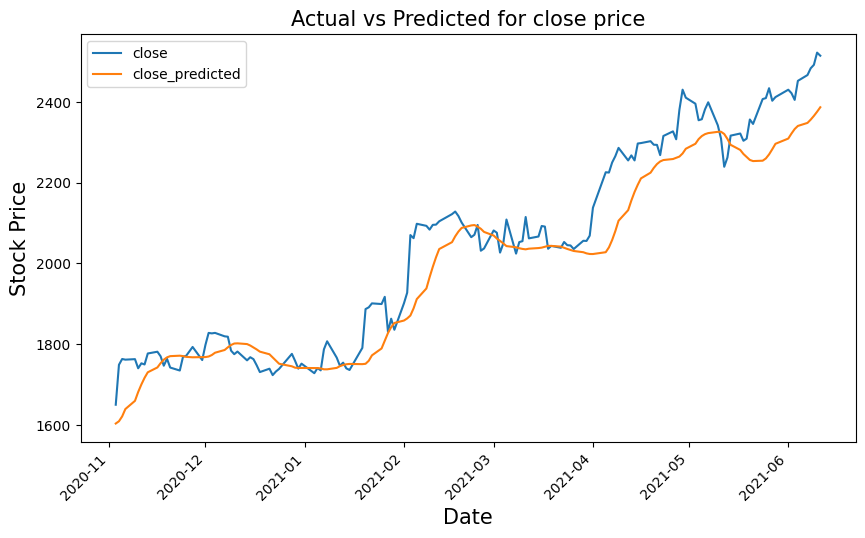

In [596]:
merged[['close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

In [597]:
merged = pd.concat([merged, pd.DataFrame(columns=merged.columns,
                                                     index=pd.date_range(start=merged.index[-1],
                                                                         periods=11,
                                                                         freq='D',
                                                                         ))])
#Added 11 more days

<ipython-input-597-7c81cb9eaec8>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat([merged, pd.DataFrame(columns=merged.columns,


In [598]:
merged[-15:] #keep

,open,close,open_predicted,close_predicted
2021-06-08,2479.90,2482.85,2419.572021,2355.728516
2021-06-09,2499.50,2491.40,2429.701660,2365.026123
2021-06-10,2494.01,2521.60,2440.907715,2375.350586
2021-06-11,2524.92,2513.93,2452.855957,2386.411865
2021-06-11,NaN,NaN,NaN,NaN
2021-06-12,NaN,NaN,NaN,NaN
2021-06-13,NaN,NaN,NaN,NaN
2021-06-14,NaN,NaN,NaN,NaN
2021-06-15,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN


# Linear Regression

In [599]:
from sklearn.linear_model import LinearRegression
X_train_2d = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

# Initialize and train the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_2d, y_train)

# Make predictions using the trained Linear Regression model
lin_predicted = lin_reg.predict(X_test_2d)
# print("linear predicted", lin_predicted)
# Evaluate the models (LSTM and Linear Regression)
# For LSTM
test_predicted = model.predict(X_test)





5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [600]:
print("Performance comparison-\n")
# For LSTM - Calculate metrics
mse_lstm = mean_squared_error(y_test, test_predicted)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, test_predicted)
r2_lstm = r2_score(y_test, test_predicted)

print(f'========================\nLSTM - RMSE: {rmse_lstm}, MAE: {mae_lstm}, R2: {r2_lstm}')

# For Linear Regression - Calculate metrics
mse_lr = mean_squared_error(y_test, lin_predicted)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, lin_predicted)
r2_lr = r2_score(y_test, lin_predicted)

print(f'========================\nLINEAR REGRESSION - RMSE: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}')

Performance comparison-

LSTM - RMSE: 0.03891271225183551, MAE: 0.029215583625316198, R2: 0.91598524245391
LINEAR REGRESSION - RMSE: 0.019932092832762587, MAE: 0.014754978631820164, R2: 0.9779558070697247


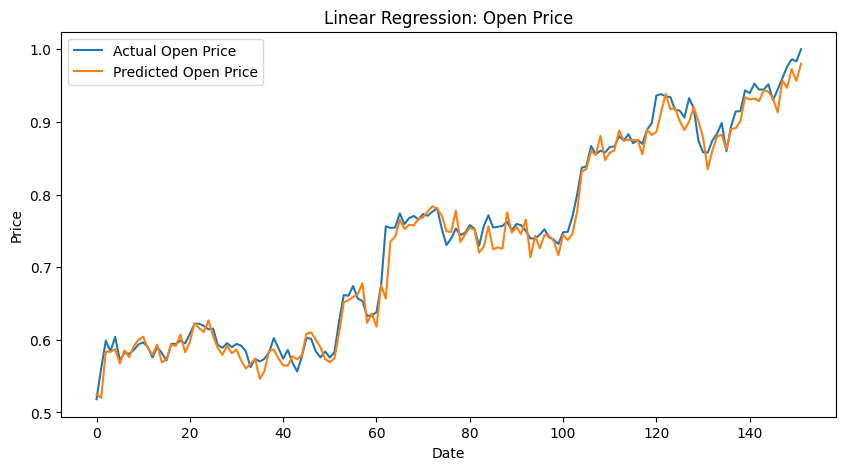

In [601]:

# Separate actual and predicted values for 'open' and 'close'
open_actual = y_test[:, 0]  # Actual open prices (first column)
close_actual = y_test[:, 1]  # Actual close prices (second column)

open_predicted_lin = lin_predicted[:, 0]  # Predicted open prices (first column)
close_predicted_lin = lin_predicted[:, 1]  # Predicted close prices (second column)

# Plot for 'open' prices
fg1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(open_actual, label='Actual Open Price')
ax1.plot(open_predicted_lin, label='Predicted Open Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.set_title('Linear Regression: Open Price')
ax1.legend()

fg1.show()


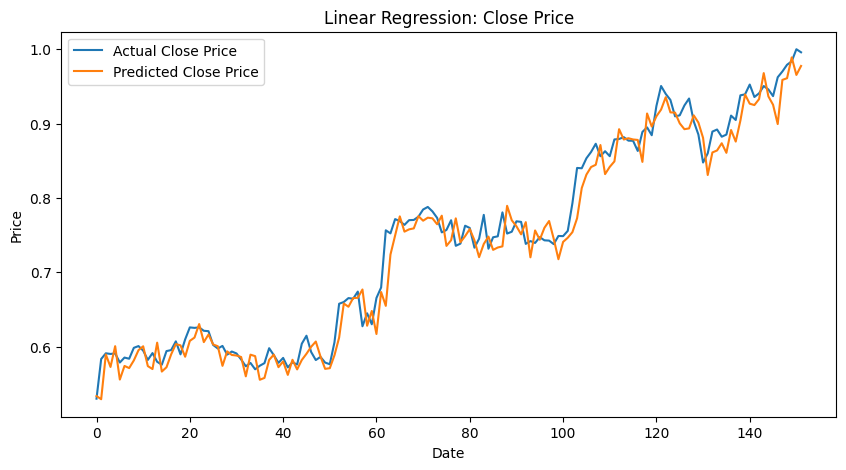

In [602]:
# Plot for 'close' prices
fg2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(close_actual, label='Actual Close Price')
ax2.plot(close_predicted_lin, label='Predicted Close Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')
ax2.set_title('Linear Regression: Close Price')
ax2.legend()

# Show the plots

fg2.show()

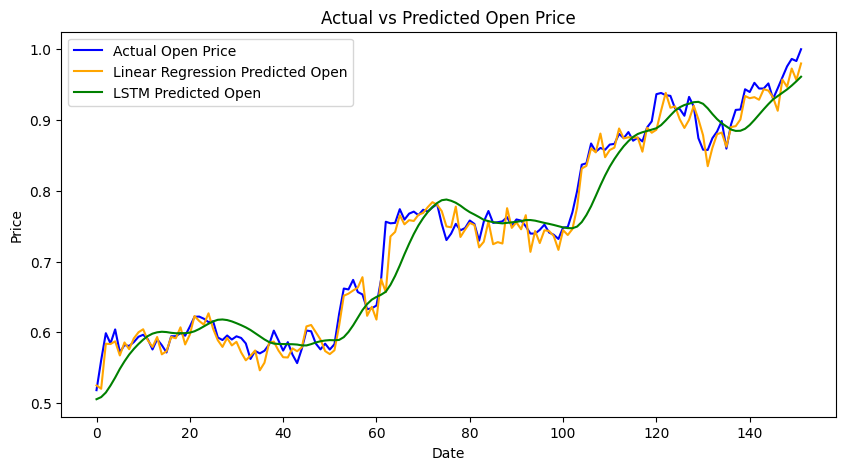

In [603]:
open_predicted_lstm = test_predicted[:, 0]  # Predicted open prices from LSTM
close_predicted_lstm = test_predicted[:, 1]  # Predicted close prices from LSTM

# Plot for 'open' prices
fg1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(open_actual, label='Actual Open Price', color='blue')
ax1.plot(open_predicted_lin, label='Linear Regression Predicted Open', color='orange')
ax1.plot(open_predicted_lstm, label='LSTM Predicted Open', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.set_title('Actual vs Predicted Open Price')
ax1.legend()
fg1.show()

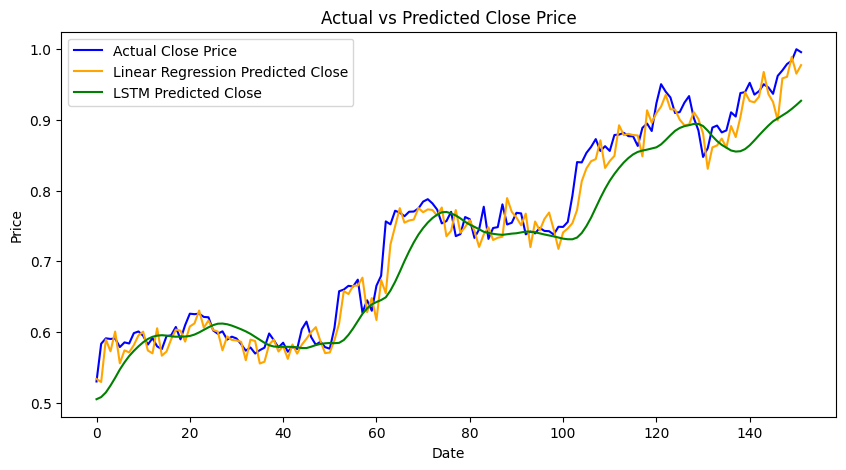

In [604]:

# Plot for 'close' prices
fg2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(close_actual, label='Actual Close Price', color='blue')
ax2.plot(close_predicted_lin, label='Linear Regression Predicted Close', color='orange')
ax2.plot(close_predicted_lstm, label='LSTM Predicted Close', color='green')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')
ax2.set_title('Actual vs Predicted Close Price')
ax2.legend()
fg2.show()